## **Assessment II - Classification of Pressurised Water Reactor Status**

**Name: Avinash Bagul**

**Id: 51987820**

---



Setting up initial requirements

In [0]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
%env JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
%env SPARK_HOME=/content/spark-2.4.5-bin-hadoop2.7
# start session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

env: JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
env: SPARK_HOME=/content/spark-2.4.5-bin-hadoop2.7


**Importing Required packages:**


In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt

**Uploading Dataset File:**

In [0]:
from google.colab import files
files.upload()

Saving dataset.csv to dataset (1).csv


{'dataset.csv': b'\xef\xbb\xbfStatus,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3 ,Power_range_sensor_4,Pressure _sensor_1,Pressure _sensor_2,Pressure _sensor_3,Pressure _sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4\nNormal,4.5044,0.7443,6.34,1.9052,29.5315,0.8647,2.2044,6.048,14.4659,21.648,15.3429,1.2186\nNormal,4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483\nNormal,4.5291,1.0199,6.113,1.0565,26.4271,1.9247,1.942,6.7162,5.3358,11.0779,25.0914,9.2408\nNormal,5.1727,1.0007,7.8589,0.2765,25.1576,2.609,2.9234,6.7485,1.9017,1.8463,28.664,4.0157\nNormal,5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.37,34.8122,13.4966\nNormal,4.8834,0.5786,5.6021,0.5942,21.0365,2.6275,4.3996,5.3487,3.6465,9.3793,36.2431,11.124\nNormal,5.7422,0.8862,5.1013,0.9402,15.5171,2.92,2.7061,5.0366,9.1854,9.1116,27.3162,2.8526\nNormal,6.5076,0.5438,7.153,0.6711,11.1481,4.2967,3.5731,4.6123,14.7705,8.0

**Reading file:**

In [0]:
mydata = spark.read.csv("dataset.csv", header=True)

In [0]:
mydata.show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [0]:
print("Dataset Shape: (",mydata.count(),",", len(mydata.columns),")")

Dataset Shape: ( 996 , 13 )


In [0]:
data_features = mydata
data_label = mydata.select('Status')

In [0]:
data_features.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: string (nullable = true)
 |-- Power_range_sensor_2: string (nullable = true)
 |-- Power_range_sensor_3 : string (nullable = true)
 |-- Power_range_sensor_4: string (nullable = true)
 |-- Pressure _sensor_1: string (nullable = true)
 |-- Pressure _sensor_2: string (nullable = true)
 |-- Pressure _sensor_3: string (nullable = true)
 |-- Pressure _sensor_4: string (nullable = true)
 |-- Vibration_sensor_1: string (nullable = true)
 |-- Vibration_sensor_2: string (nullable = true)
 |-- Vibration_sensor_3: string (nullable = true)
 |-- Vibration_sensor_4: string (nullable = true)



**Sensor data statistics**


In [0]:
feature = data_features.drop("Status")
feature.describe().show()

+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|             label|
+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                  996|                 996|               996|               996|               996|               996|               996|             

detailed description can be achieved using pandas


In [0]:
dt = pd.read_csv("dataset.csv")
dt.columns = ['status','prs1','prs2','prs3','prs4','ps1','ps2','ps3','ps4','vs1','vs2','vs3','vs4']

Data description using pandas: count, mean, std, min,25%, 50%, 75%, max.

In [0]:
dt.describe()

,prs1,prs2,prs3,prs4,ps1,ps2,ps3,ps4,vs1,vs2,vs3,vs4
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,4.999574,6.379273,9.228112,7.355272,14.199127,3.077958,5.749234,4.997002,8.164563,10.001593,15.187982,9.933591
std,2.764856,2.312569,2.532173,4.354778,11.680045,2.126091,2.526136,4.165490,6.173261,7.336233,12.159625,7.282383
min,0.008200,0.040300,2.583966,0.062300,0.024800,0.008262,0.001224,0.005800,0.000000,0.018500,0.064600,0.009200
25%,2.892120,4.931750,7.511400,3.438141,5.014875,1.415800,4.022800,1.581625,3.190292,4.004200,5.508900,3.842675
50%,4.881100,6.470500,9.348000,7.071550,11.716802,2.672400,5.741357,3.859200,6.752900,8.793050,12.185650,8.853050
75%,6.794557,8.104500,11.046800,10.917400,20.280250,4.502500,7.503578,7.599900,11.253300,14.684055,21.835000,14.357400
max,12.129800,11.928400,15.759900,17.235858,67.979400,10.242738,12.647500,16.555620,36.186438,34.867600,53.238400,43.231400


Checking for NULL Value: using pandas

In [0]:
print("null values: \n",dt.isnull().sum())

null values: 
 status    0
prs1      0
prs2      0
prs3      0
prs4      0
ps1       0
ps2       0
ps3       0
ps4       0
vs1       0
vs2       0
vs3       0
vs4       0
dtype: int64


checking null values using pyspark



In [0]:
from functools import reduce
import pyspark.sql.functions as F

data_agg = data_features.agg(*[F.count(F.when(F.isnull(item), item)).alias(item) for item in data_features.columns])
n_val = reduce(
    lambda a, b: a.union(b),
    (
        data_agg.select(F.lit(item).alias("Column_Name"), F.col(item).alias("NULL Values")) 
        for item in data_agg.columns
    )
)
print("Total Null Values in Columns: \n\n")
n_val.show()

Total Null Values in Columns: 


+--------------------+-----------+
|         Column_Name|NULL Values|
+--------------------+-----------+
|              Status|          0|
|Power_range_sensor_1|          0|
|Power_range_sensor_2|          0|
|Power_range_senso...|          0|
|Power_range_sensor_4|          0|
|  Pressure _sensor_1|          0|
|  Pressure _sensor_2|          0|
|  Pressure _sensor_3|          0|
|  Pressure _sensor_4|          0|
|  Vibration_sensor_1|          0|
|  Vibration_sensor_2|          0|
|  Vibration_sensor_3|          0|
|  Vibration_sensor_4|          0|
+--------------------+-----------+



**Data Analysis & Visualization**

In [0]:
dt.groupby("status").count()

,prs1,prs2,prs3,prs4,ps1,ps2,ps3,ps4,vs1,vs2,vs3,vs4
status,,,,,,,,,,,,
Abnormal,498,498,498,498,498,498,498,498,498,498,498,498
Normal,498,498,498,498,498,498,498,498,498,498,498,498


**Box Plot**

---



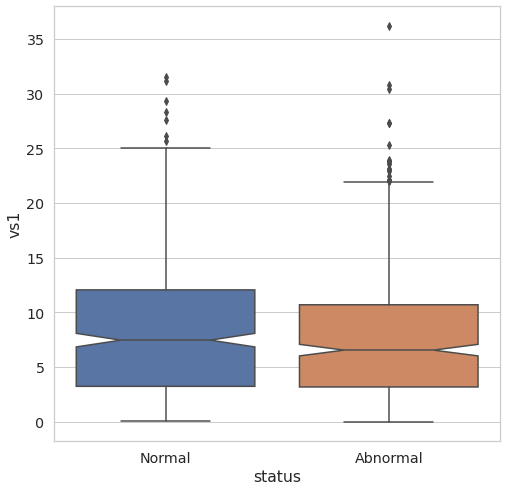

In [0]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.3,style='whitegrid', palette="deep")
ax = sns.boxplot(x="status", y="vs1", data=dt, dodge=False, notch=True)
plt.show()

In [0]:
dt_normal = dt[dt['status'] == 'Normal']
dt_abnormal = dt[dt['status'] == 'Abnormal']

**Density Plot**

---



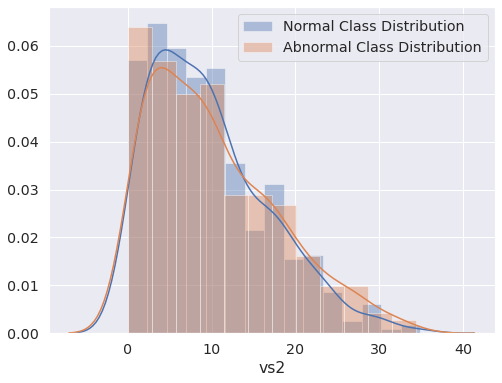

In [0]:
plt.figure(figsize=(8,6))
sns.distplot(dt_normal['vs2'], label='Normal Class Distribution')
sns.distplot(dt_abnormal['vs2'], label='Abnormal Class Distribution')
plt.legend()
plt.show()

## **Logistic Regression Model**

In [0]:
indexer = StringIndexer(inputCol="Status", outputCol="label")
data_features = indexer.fit(data_features).transform(data_features)
data_features = data_features.withColumn("featuresTmp", data_features["label"].cast(IntegerType())).drop("label").withColumnRenamed("featuresTmp", "label")
data_features = data_features.drop("Status")

In [0]:
data_features.show(10)

+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|label|
+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|    0|
|              4.428

Scaling data_features 

In [0]:
def convt(info, items, Type):
    for item in items: 
        info = info.withColumn(item, info[item].cast(Type))
    return info
data_features = convt(data_features, data_features.columns[1:], IntegerType())

In [0]:
assembler = VectorAssembler(inputCols=data_features.columns[1:-1], outputCol="features")
pred = assembler.transform(data_features)
scale = StandardScaler(inputCol="features", outputCol="scaled_features")
pred = scale.fit(pred).transform(pred)
model = pred.select("scaled_features", "label")
model.show(5)

+--------------------+-----+
|     scaled_features|label|
+--------------------+-----+
|[0.0,2.3478864946...|    0|
|[0.0,1.9565720788...|    0|
|[0.42972040085464...|    0|
|[0.42972040085464...|    0|
|[0.0,2.7392009104...|    0|
+--------------------+-----+
only showing top 5 rows



**Test/Train Split:**

In [0]:
train_data, test_data = model.randomSplit([.75,.25])
print("Number of Training Dataset: ",train_data.count())
print("Number of Test Dataset: ",test_data.count())

Number of Training Dataset:  737
Number of Test Dataset:  259


### **Function to show Evaluation results**

In [0]:
def show_result(p_tr,p_ts):

  precision = MulticlassClassificationEvaluator(metricName='weightedPrecision', labelCol='label')
  auc = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='label')
  recall = MulticlassClassificationEvaluator(metricName='weightedRecall', labelCol='label')
  acc = MulticlassClassificationEvaluator(metricName='accuracy', labelCol='label')

  print("\n******************************* Training Data Evaluation *****************************\n")
  
  print('Precision................. ', precision.evaluate(p_tr))
  print('Accuracy.................. ', acc.evaluate(p_tr))
  print('Area Under ROC............ ', auc.evaluate(p_tr))
  print('Recall.................... ', recall.evaluate(p_tr))
  print('\n\n')

  print("\n******************************* Testing Data Evaluation *****************************\n")
  
  print('Precision................. ', precision.evaluate(p_ts))
  print('Accuracy.................. ', acc.evaluate(p_ts))
  print('Area Under ROC............ ', auc.evaluate(p_ts))
  print('Recall.................... ', recall.evaluate(p_ts))
  print('\n\n')


	

In [0]:
regression = LogisticRegression(featuresCol="scaled_features", labelCol="label", maxIter=100, regParam=0.3, elasticNetParam=0.8)
regression_Model = regression.fit(train_data)
regression_Model.summary.accuracy

0.7245590230664858

In [0]:
pred_train = regression_Model.transform(train_data)
pred_test = regression_Model.transform(test_data)

print("  Pred Train: \n")
print(pred_train.show(3))

print("\n\n  Pred Test:  \n")
print(pred_test.show(3))

print("\n Evaluation Metric Result:\n")
show_result(pred_train, pred_test)

  Pred Train: 

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,1.5652576630...|    0|[-2.0133110861100...|[0.11781241214523...|       1.0|
|[0.0,1.5652576630...|    1|[-2.7854484188230...|[0.05811560001103...|       1.0|
|[0.0,1.9565720788...|    0|[-2.5457275514675...|[0.07271403711266...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows

None


  Pred Test:  

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,1.9565720788...|    0|[-2.2202276164502...|[0.09794869146356...|       1.0|
|[0.0,1.9565720788...|    1|[-3.07

## **Gradient Boosted Tree Classifier**

In [0]:
gboost = GBTClassifier(featuresCol = "scaled_features",labelCol="label",  maxIter = 100, maxDepth=5)
gboost_model = gboost.fit(train_data)

In [0]:
p_train = gboost_model.transform(train_data)
p_test = gboost_model.transform(test_data)

print("  Pred Train: \n")
print(p_train.show(3))

print("\n\n  Pred Test:  \n")
print(p_test.show(3))

print("\n Evaluation Metric Result:\n")
show_result(p_train, p_test)

  Pred Train: 

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,1.5652576630...|    0|[1.48987340668216...|[0.95165072308378...|       0.0|
|[0.0,1.5652576630...|    1|[-2.0303631423426...|[0.01694443330880...|       1.0|
|[0.0,1.9565720788...|    0|[1.82341187597048...|[0.97458875381756...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows

None


  Pred Test:  

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,1.9565720788...|    0|[2.24090962414300...|[0.98881373453046...|       0.0|
|[0.0,1.9565720788...|    1|[-0.80

## **Conclusion**

---
Gradient Boosted Tree Classifier performed better than Logistic Regression Model.